In [111]:
#conda install -c districtdatalabs yellowbrick
import pandas as pd
import numpy as np
# from ydata_profiling import ProfileReport
import sklearn
# sklearn.set_config(transform_output="pandas")
# import pandas as pd
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn import preprocessing

import seaborn as sns
import matplotlib.pyplot as plt

labeller  =  preprocessing.LabelEncoder()
ohe = preprocessing.OneHotEncoder()

In [112]:
order_items = pd.read_csv('./dataset/olist_order_items_dataset.csv')
customers = pd.read_csv('./dataset/olist_customers_dataset.csv')
sellers = pd.read_csv('./dataset/olist_sellers_dataset.csv')
products = pd.read_csv('./dataset/olist_products_dataset.csv')
orders = pd.read_csv('./dataset/olist_orders_dataset.csv')
reviews = pd.read_csv('./dataset/olist_order_reviews_dataset.csv')
geos = pd.read_csv('./dataset/olist_geolocation_dataset.csv')



In [113]:
# orders.info()
# order_items.info()

In [114]:

orders[['order_purchase_timestamp',
        'order_approved_at',
        'order_delivered_carrier_date',
        'order_delivered_customer_date',
        'order_estimated_delivery_date']] = orders[['order_purchase_timestamp',
                                                    'order_approved_at',
                                                    'order_delivered_carrier_date',
                                                    'order_delivered_customer_date',
                                                    'order_estimated_delivery_date']].apply(pd.to_datetime) 
reviews[['review_creation_date',
        'review_answer_timestamp']] = reviews[['review_creation_date',
                                                    'review_answer_timestamp']].apply(pd.to_datetime) 
order_items[['shipping_limit_date']] = order_items[['shipping_limit_date']].apply(pd.to_datetime)
# order_items.info(),orders.info()
# order_items.head()
# customers.head(),order_items.head(),orders.head(),customers[customers['customer_id'] == "9ef432eb6251297304e76186b10a928d"], customers[customers['customer_unique_id'] == "9ef432eb6251297304e76186b10a928d"]
# ProfileReport(order_items,title="order of items").to_widgets()

# orders.info()
merged = orders.merge(order_items, how='inner')

merged = merged.merge(customers)
# merged.info()
merged = merged.merge(sellers)
merged = merged.merge(products)
merged = merged.merge(reviews)


merged['product_photos_qty']=merged['product_photos_qty'].fillna(0)
# merged[merged['product_photos_qty'].isna()][['customer_id','product_photos_qty']]

# merged[['seller_city','seller_state','customer_city','customer_state']] = merged[['seller_city','seller_state','customer_city','customer_state']].astype('category') 
# merged[['seller_city','seller_state','customer_city','customer_state']].info()
# print(merged[['seller_city','seller_state','customer_city','customer_state','review_score']].head())
# print(merged['customer_city'].value_counts())
# merged['seller_city'] = labeller.fit_transform(merged['seller_city'].astype('str'))
# merged['seller_state'] = labeller.fit_transform(merged['seller_state'].astype('str'))
# merged['customer_city'] = labeller.fit_transform(merged['customer_city'].astype('str'))
# merged['customer_state'] = labeller.fit_transform(merged['customer_state'].astype('str'))
merged['review_score'] = labeller.fit_transform(merged['review_score'].astype('str'))

# print(merged[['seller_city','seller_state','customer_city','customer_state','review_score']].head())
# merged[['seller_city','seller_state','customer_city','customer_state','review_score']].info()


merged['time_to_get'] = merged.order_delivered_customer_date - merged['order_purchase_timestamp']
merged['time_to_get'] = merged['time_to_get'].dt.seconds/(60*60)
merged['time_to_get'] = merged['time_to_get']

merged.sort_values(by='order_purchase_timestamp',inplace=True)
# merged['time_to_get'] = merged['time_to_get'].replace(np.nan, 0)
# merged.time_to_get.isna().sum()
merged.dropna(subset=['price'],inplace=True)
# print(merged.info())



In [115]:

# merged[['price']].hist(figsize=(15,15))

In [116]:
# merged.hist(figsize=(15,15),xlabelsize=7,ylabelsize=7)

In [117]:
# one hot encoding on the seller city and customer city
tohe = ohe.fit_transform(merged[['seller_city']])
one_hot = pd.get_dummies(merged['seller_city'], prefix='seller_from')
merged = pd.concat([merged, one_hot], axis=1)


tohe = ohe.fit_transform(merged[['customer_city']])
one_hot = pd.get_dummies(merged['customer_city'], prefix='customer_from')
merged = pd.concat([merged, one_hot], axis=1)




In [118]:
merged.dropna(subset=['order_approved_at', 'product_length_cm', 'product_height_cm', 'product_width_cm',
                      'order_delivered_carrier_date', 'order_delivered_customer_date', 'product_category_name',
       'product_name_lenght', 'product_description_lenght','time_to_get'],inplace=True)
merged.fillna(value={'review_comment_title':'no comment', 'review_comment_message':'no_comment'},inplace=True)


# print(merged.info())
# print(len(merged.index))

In [119]:
#some dropper
oriC = np.array( merged.columns)
# ['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
#        'order_approved_at', 'order_delivered_carrier_date',
#        'order_delivered_customer_date', 'order_estimated_delivery_date',
#        'order_item_id', 'product_id', 'seller_id', 'shipping_limit_date',
#        'price', 'freight_value', 'customer_unique_id',
#        'customer_zip_code_prefix', 'customer_city', 'customer_state',
#        'seller_zip_code_prefix', 'seller_city', 'seller_state',
#        'product_category_name', 'product_name_lenght',
#        'product_description_lenght', 'product_photos_qty', 'product_weight_g',
#        'product_length_cm', 'product_height_cm', 'product_width_cm',
#        'review_id', 'review_score', 'review_comment_title',
#        'review_comment_message', 'review_creation_date',
#        'review_answer_timestamp', 'time_to_get']
dropped_features = np.delete(oriC,np.where(np.isin(oriC,[
       # 'order_id','review_score',   'time_to_get', 'price', 'freight_value', 'review_score',
       'order_status', 
       'customer_id',       
       'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date',
       'order_item_id', 'product_id', 

       'seller_id', 'shipping_limit_date','customer_unique_id',
       'customer_zip_code_prefix', 
       'customer_city', 'customer_state',
       'seller_zip_code_prefix', 
       'seller_city', 'seller_state',

       'product_category_name', 'product_name_lenght',
       'product_description_lenght', 
       'product_photos_qty', 'product_weight_g',
       'product_length_cm', 'product_height_cm', 'product_width_cm',

       'review_id', 'review_comment_title',
       'review_comment_message', 'review_creation_date',
       'review_answer_timestamp'])))

# onlyThis

In [120]:
# merged[['price','freight_value','seller_city','seller_state'
#             ,'customer_city','customer_state','time_to_get']].isna().any().any()

<Axes: >

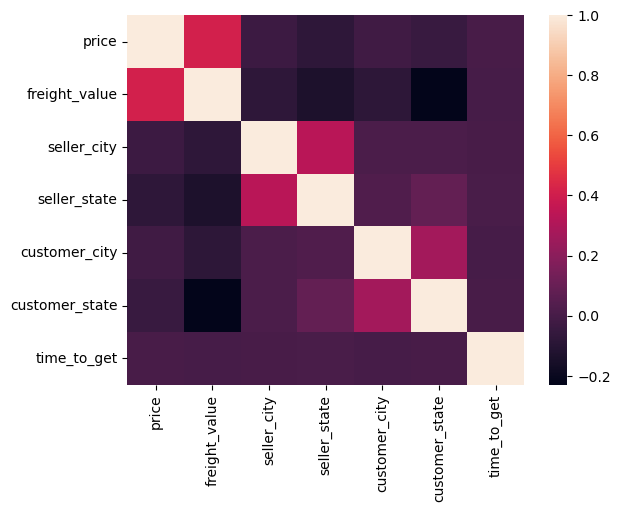

In [121]:
#without further preprocessing
merged['seller_city'] = labeller.fit_transform(merged['seller_city'].astype('str'))
merged['seller_state'] = labeller.fit_transform(merged['seller_state'].astype('str'))
merged['customer_city'] = labeller.fit_transform(merged['customer_city'].astype('str'))
merged['customer_state'] = labeller.fit_transform(merged['customer_state'].astype('str'))

X = merged[['price','freight_value','seller_city','seller_state'
            ,'customer_city','customer_state','time_to_get']]
# merged['review_score_transformed'] = merged['review_score']-1

# first we are goin to map seller_city and seller_satate and its customer conterpart to  unique integer,later we are also going to test one hot encoding
y = merged['review_score']


sns.heatmap(X.corr())

In [122]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train the XGBoost model
xgb_model = xgb.XGBClassifier()
xgb_model.fit(X_train, y_train)

# Train the Random Forest model
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)


# Train the SVM model
# svm_model = SVC()
# svm_model.fit(X_train, y_train)

# # Make predictions on the test set
xgb_pred = xgb_model.predict(X_test)
rf_pred = rf_model.predict(X_test)

# svm_pred = svm_model.predict(X_test)

# # Classification report for XGBoost model
# xgb_report = classification_report(y_test, xgb_pred)
# print("XGBoost Classification Report:")
# print(xgb_report)

# # # Classification report for Random Forest model
# rf_report = classification_report(y_test, rf_pred)
# print("Random Forest Classification Report:")
# print(rf_report)




# # Classification report for SVM model
# svm_report = classification_report(y_test, svm_pred)
# print("SVM Classification Report:")
# print(svm_report)


In [123]:
# Train the Random Logistic Regression
# logreg_model = LogisticRegression(multi_class='multinomial', solver='lbfgs',max_iter=200000)
# logreg_model.fit(X_train,y_train)

# logr_pred = logreg_model.predict(X_test)

# logr_report = classification_report(y_test, logr_pred,zero_division=0)
# print("Logistic Regression Classification Report:")
# print(logr_report)



In [124]:
# reports = [logr_report,xgb_report,rf_report]
# reports_name = ['mlr','xgb','rforest']


# import matplotlib.pyplot as plt
# # from sklearn.metrics import classification_report
# accuracy_list = []
# model_labels = []

# # Iterate over the classification reports
# for i, report in enumerate(reports):
#     # Split the report lines and extract the accuracy value
#     # print(lines)
#     # print(report)
#     lines = report.split('\n')
#     accuracy_line = lines[8]
#     accuracy = float(accuracy_line.split()[-2])

#     # Add accuracy to the list
#     accuracy_list.append(accuracy)
#     model_labels.append(f"{reports_name[i]} Accuracy")

# # Plot the accuracy values
# plt.figure(figsize=(10, 6))
# x = range(len(model_labels))
# plt.bar(x, accuracy_list)
# plt.xticks(x, model_labels)
# # plt.xlabel('Models')
# plt.ylabel('Accuracy')
# plt.title('Accuracy of Classification Models')
# plt.show()




In [ ]:
# import scikitplot as skplt
# from sklearn.metrics import confusion_matrix

# skplt.metrics.plot_confusion_matrix(y_test, xgb_pred, normalize=False, title = 'xgb')
# skplt.metrics.plot_confusion_matrix(y_test, rf_pred, normalize=False, title = 'rf' )
# skplt.metrics.plot_confusion_matrix(y_test, logr_pred, normalize=False, title = 'logreg')

# from sklearn.metrics import confusion_matrix
# models ={
#     "XGB":xgb_pred,
#     "Random Forest":rf_pred
# }
# cf_matrix = dict.fromkeys(models.keys())
# for key, pred in models.items(): 
#     # y_pred = classifier.fit(X_train, y_train.values.ravel()).predict(X_test)
#     cf_matrix[key]=confusion_matrix(y_test, pred)


# print(list(cf_matrix))
# fig, axs = plt.subplots(2,2,figsize=(10,10))
# print(list(axs.flat))
# for i,ax in enumerate(axs.flat):
#     k = list(cf_matrix)[i]
#     sns.heatmap(cf_matrix[k], ax=ax,cbar=i==4)
#     ax.set_title(k,fontsize=8)

Text(0.5, 0.98, 'RF')

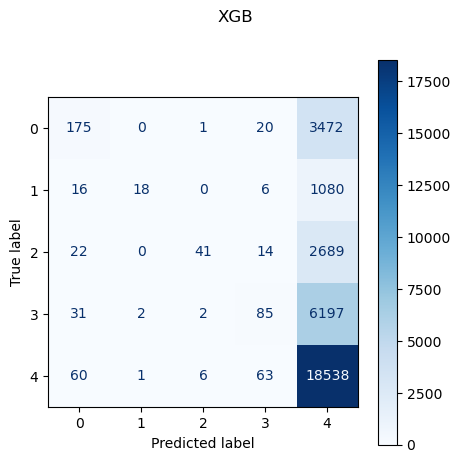

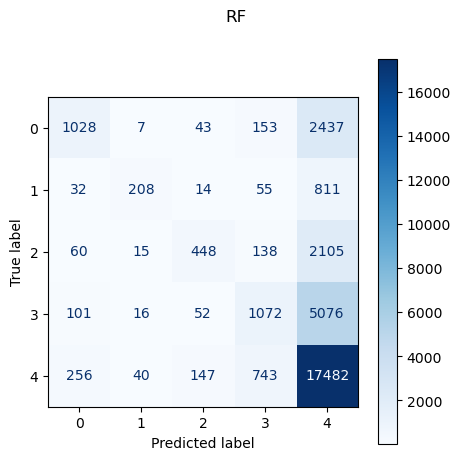

In [128]:
from sklearn.metrics import ConfusionMatrixDisplay

# fg, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2, 2, figsize=(10, 8))
disp = ConfusionMatrixDisplay.from_predictions(
                                              y_test, 
                                              xgb_pred, 
                                            #   display_labels=labels, 
                                              cmap=plt.cm.Blues
                                              ) 
fig = disp.figure_
fig.set_figwidth(5)
fig.set_figheight(5) 
fig.suptitle('XGB')


disp = ConfusionMatrixDisplay.from_predictions(
                                              y_test, 
                                              rf_pred, 
                                            #   display_labels=labels, 
                                              cmap=plt.cm.Blues
                                              ) 
fig2 = disp.figure_
fig2.set_figwidth(5)
fig2.set_figheight(5) 
fig2.suptitle('RF')


# models ={
#     "XGB":xgb_pred,
#     "Random Forest":rf_pred
# }
# f, axes = plt.subplots(1, 2, figsize=(20, 5), sharey='row')

# for i, (key, pred) in enumerate(models.items()):    
#     disp = ConfusionMatrixDisplay.from_predictions(y_test,pred,cmap=plt.cm.Blues)
#     disp.plot(ax=axes[i], xticks_rotation=45)
#     disp.ax_.set_title(key)
#     disp.im_.colorbar.remove()
#     disp.ax_.set_xlabel('')
#     if i!=0:
#         disp.ax_.set_ylabel('')
# # 
# f.text(0.4, 0.1, 'Predicted label', ha='left')
# plt.subplots_adjust(wspace=0.40, hspace=0.1)


# f.colorbar(disp.im_, ax=axes)
# plt.show()


In [ ]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.datasets import load_iris
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
# from sklearn.ensemble import RandomForestClassifier

classifiers = {
    "Naive Bayes": GaussianNB(),
    "LogisiticRegression": LogisticRegression(),
    "KNearest": KNeighborsClassifier(),
    "Support Vector Classifier": SVC(),
    "DecisionTreeClassifier": DecisionTreeClassifier(),
}


iris = load_iris()
X, y = iris.data, iris.target

X_train, X_test, y_train, y_test = train_test_split(X, y)


f, axes = plt.subplots(1, 5, figsize=(20, 5), sharey='row')

for i, (key, classifier) in enumerate(classifiers.items()):
    y_pred = classifier.fit(X_train, y_train).predict(X_test)
    cf_matrix = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(cf_matrix,
                                  display_labels=iris.target_names)
    disp.plot(ax=axes[i], xticks_rotation=45)
    disp.ax_.set_title(key)
    disp.im_.colorbar.remove()
    disp.ax_.set_xlabel('')
    if i!=0:
        disp.ax_.set_ylabel('')

f.text(0.4, 0.1, 'Predicted label', ha='left')
plt.subplots_adjust(wspace=0.40, hspace=0.1)


f.colorbar(disp.im_, ax=axes)
plt.show()


In [ ]:
# disp = ConfusionMatrixDisplay.from_predictions(
#                                               y_test, 
#                                               xgb_pred, 
#                                             #   display_labels=labels, 
#                                               cmap=plt.cm.Blues
#                                               ) 
# fig = disp.figure_
# fig.set_figwidth(5)
# fig.set_figheight(5) 
# fig.suptitle('XGB')

# disp = ConfusionMatrixDisplay.from_predictions(
#                                               y_test, 
#                                               rf_pred, 
#                                             #   display_labels=labels, 
#                                               cmap=plt.cm.Blues
#                                               ) 
# fig = disp.figure_
# fig.set_figwidth(5)
# fig.set_figheight(5) 
# fig.suptitle('RF')

In [ ]:
# from lightgbm import LGBMClassifier

# LGBMC = LGBMClassifier()
# merged.review_score.value_counts().plot(kind='bar')

# merged.pivot_table(index='review_score',aggfunc='count')


# print(merged.columns[ merged.isna().any()])
# print(merged[['order_approved_at', 'order_delivered_carrier_date',
#        'order_delivered_customer_date', 'product_category_name',
#        'product_name_lenght', 'product_description_lenght', 
#        'product_weight_g','product_length_cm', 'product_height_cm', 
#        'product_width_cm','review_comment_title', 'review_comment_message', 
#        'time_to_get']].isna().sum())
# merged.info()

# ORIGINAL FEATURES
# ['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
#        'order_approved_at', 'order_delivered_carrier_date',
#        'order_delivered_customer_date', 'order_estimated_delivery_date',
#        'order_item_id', 'product_id', 'seller_id', 'shipping_limit_date',
#        'price', 'freight_value', 'customer_unique_id',
#        'customer_zip_code_prefix', 'customer_city', 'customer_state',
#        'seller_zip_code_prefix', 'seller_city', 'seller_state',
#        'product_category_name', 'product_name_lenght',
#        'product_description_lenght', 'product_photos_qty', 'product_weight_g',
#        'product_length_cm', 'product_height_cm', 'product_width_cm',
#        'review_id', 'review_score', 'review_comment_title',
#        'review_comment_message', 'review_creation_date',
#        'review_answer_timestamp', 'time_to_get']

    * Data Resampling: Data resampling techniques involve either oversampling the minority class or undersampling the majority class to achieve a balanced distribution.
    * Oversampling: It involves creating synthetic samples for the minority class, such as using techniques like SMOTE, ADASYN, or random oversampling.
    * Undersampling: It involves randomly removing samples from the majority class, reducing its dominance. It can be achieved using techniques like RandomUnderSampler, Tomek links, or Cluster Centroids.
    * Class Weighting: Many machine learning algorithms allow assigning higher weights to minority class samples during model training. This gives more importance to the minority class and helps to mitigate the impact of class imbalance. Class weights can be manually specified or automatically computed based on the class frequencies.
    * Algorithmic Approaches: Certain algorithms are inherently robust to class imbalance or have built-in techniques to handle it. For example:
    * Decision Trees: Decision trees can naturally handle imbalanced datasets by splitting nodes based on the class distribution.
    * Ensemble Methods: Ensemble algorithms like Random Forest and Gradient Boosting are often effective in dealing with class imbalance due to their aggregation of multiple models.
    * Cost-Sensitive Learning: Cost-sensitive learning involves assigning misclassification costs to different classes. It aims to minimize the cost of misclassifying the minority class by penalizing such errors more heavily during model training.
    * Collect More Data: Increasing the amount of data, particularly for the minority class, can help address imbalance. Obtaining more samples can improve the representation of the minority class, making the model more robust.

--------
    Determining the number of new rows to generate for the minority class in an imbalanced dataset is not a straightforward task and depends on several factors. There is no fixed rule or a universally applicable threshold for the number of new rows that would be considered a "healthy addition." The appropriate number of new rows can vary depending on the specific problem, the available data, and the degree of class imbalance.

Here are a few considerations to help guide the decision-making process:

    Proportional Representation: Aim to achieve a more balanced distribution by increasing the representation of the minority class. The goal is to have a proportionate number of samples across classes. However, it's important to strike a balance and not over-represent the minority class to the extent that it dominates the dataset.

    Impact on Performance: Consider the impact of the generated samples on the overall model performance. Generating too few samples may not sufficiently address the imbalance, while generating too many samples can introduce noise or overfitting. It's advisable to monitor the performance of the model on a validation set or through cross-validation to find the optimal number of new rows.

    Domain Knowledge: Take into account the characteristics of the specific problem domain. Some domains may inherently have a high degree of class imbalance, while others may require a more balanced representation. Consulting with domain experts or understanding the consequences of misclassifications can help guide the decision.

    Available Data: Consider the size and quality of the original dataset. If the original dataset is small, generating a large number of new rows for the minority class might lead to an over-reliance on synthetic samples. Conversely, if the original dataset is large, generating a moderate number of new rows may be sufficient to address the imbalance.

    Evaluation Metrics: Assess the model's performance using appropriate evaluation metrics, such as precision, recall, F1 score, or area under the ROC curve (AUC-ROC). Iteratively adjust the number of generated samples until the desired performance is achieved.

It is recommended to experiment with different numbers of generated samples and monitor the model's performance on validation data to find the optimal balance between addressing class imbalance and preserving the generalization ability of the model.